In [15]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [16]:
import pickle as pkl
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from medmnist import INFO
import torch
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score, recall_score
from torch_uncertainty.metrics.classification import AURC
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from utils import train_load_datasets_resnet as tr
import UQ_toolbox as uq
import math

In [17]:
with open('/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/medMNIST/medMNIST_UQ_results/model_global_perfs_augmented.pkl', 'rb') as f:
    results_augmented = pkl.load(f)
    
with open('/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/medMNIST/medMNIST_UQ_results/model_global_perfs.pkl', 'rb') as f:
    results = pkl.load(f)
    
with open('/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/medMNIST/medMNIST_UQ_results/model_scores_augmented.pkl', 'rb') as f:
    scores_augmented = pkl.load(f)
    
with open('/mnt/data/psteinmetz/computer_vision_code/code/UQ_Toolbox/medMNIST/medMNIST_UQ_results/model_scores.pkl', 'rb') as f:
    scores = pkl.load(f)

In [18]:
def get_fail_and_success(scores):
    # Create a dictionary mapping each dataset to a list of 0 (failure) or 1 (success) for each prediction
    success_failure_dict = {}
    for ds_name, ds_scores in scores.items():
        y_true = ds_scores['y_true']
        y_scores = ds_scores['y_scores']

        # Binary-class: y_scores is 1D, multi-class: y_scores is 2D logits
        info = INFO[ds_name]
        task_type = info['task']
        if 'binary-class' in task_type:
            # Success if prediction matches true label (threshold 0.5)
            preds = (y_scores > 0.5).astype(int)
            success_failure = (preds == y_true).astype(int)
        else:
            # Success if argmax of scores matches true label
            preds = np.argmax(y_scores, axis=1)
            success_failure = (preds == y_true).astype(int)

        success_failure_dict[ds_name] = success_failure.tolist()

    return success_failure_dict

In [19]:
def compute_aurc(uq_values, success_labels):
    """
    uq_values: iterable of uncertainty scores (lower = more confident)
    success_labels: list/array of 0/1 (1 = correct prediction)
    """
    v = torch.tensor(uq_values, dtype=torch.float32)
    lab = torch.tensor(success_labels, dtype=torch.float32)
    if len(v) != len(lab) or len(v) == 0:
        return math.nan
    order = torch.argsort(v, descending=False)
    ordered_lab = lab[order]
    k = torch.arange(1, len(v)+1, dtype=torch.float32)
    cum_correct = torch.cumsum(ordered_lab, dim=0)
    accuracy_prefix = cum_correct / k
    risk = 1.0 - accuracy_prefix  # error rate among retained
    coverage = k / len(v)
    aurc = torch.trapz(risk, coverage).item()
    return aurc

In [20]:
success_failure_dict = get_fail_and_success(scores)
success_failure_dict_augmented = get_fail_and_success(scores_augmented)

/tmp/ipykernel_4043364/3790714309.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(uq_values, dtype=torch.float32)


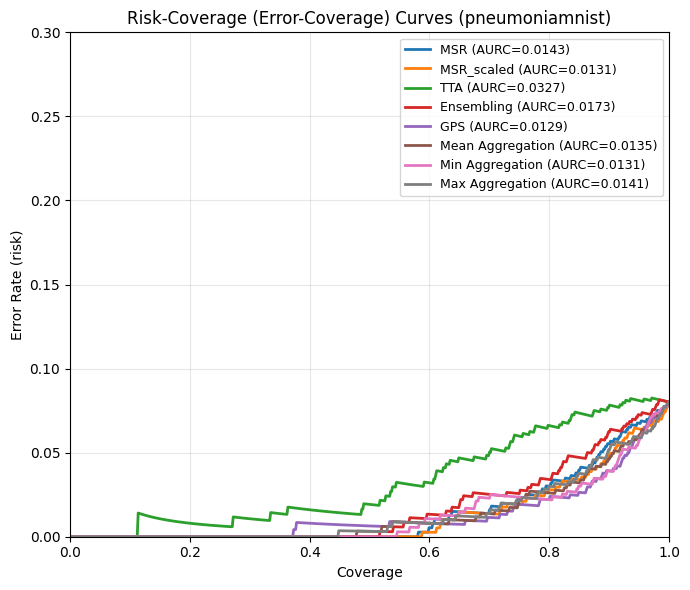

AURC scores:
  MSR: 0.014333
  MSR_scaled: 0.013068
  TTA: 0.032723
  Ensembling: 0.017337
  GPS: 0.012936
  Mean Aggregation: 0.013528
  Min Aggregation: 0.013113
  Max Aggregation: 0.014059


In [24]:
flag = 'pneumoniamnist'   # change if needed

# Include aggregation curves (mean/min/max)
methods_to_plot = ['MSR', 'MSR_temp_scale', 'TTA', 'Ensembling', 'GPS', #'KNNshap',
                   'Mean Aggregation', 'Min Aggregation', 'Max Aggregation']
display_name = {'MSR_temp_scale': 'MSR_scaled'}

uq_metrics_list = dict(results[flag]['uq_metrics'])

if flag not in success_failure_dict:
    raise KeyError(f"'{flag}' not found in success_failure_dict. Available keys: {list(success_failure_dict.keys())}")

labels_tensor = torch.tensor(success_failure_dict[flag], dtype=torch.int64)  # 1=correct, 0=incorrect

# Build aggregation vectors for this dataset (over selected base methods)
base_for_agg = ['MSR_temp_scale', 'Ensembling', 'GPS']#, 'KNNshap']
cols = [np.asarray(uq_metrics_list[m], dtype=float) for m in base_for_agg if m in uq_metrics_list]
if len(cols) >= 2:
    mat = np.column_stack(cols)
    uq_metrics_list['Mean Aggregation'] = uq.standardize_and_ensemble(mat, 'mean')
    uq_metrics_list['Min Aggregation']  = uq.standardize_and_ensemble(mat, 'min')
    uq_metrics_list['Max Aggregation']  = uq.standardize_and_ensemble(mat, 'max')

aurc_summary = {}
fig, ax = plt.subplots(figsize=(7,6))

for m in methods_to_plot:
    if m not in uq_metrics_list:
        print(f"[WARN] Method '{m}' not found for {flag}, skipping.")
        continue

    vals = torch.tensor(uq_metrics_list[m], dtype=torch.float32)

    # Sort by uncertainty ascending (most confident first)
    order = torch.argsort(vals, descending=False)
    ordered_labels = labels_tensor[order].float()  # 1=correct
    k = torch.arange(1, len(vals)+1, dtype=torch.float32)
    cum_correct = torch.cumsum(ordered_labels, dim=0)
    coverage = k / len(vals)
    accuracy_prefix = cum_correct / k
    error_rate = 1.0 - accuracy_prefix  # error rate among retained samples

    # AURC via the shared helper
    aurc = compute_aurc(vals, labels_tensor.tolist())
    aurc_summary[m] = aurc
    ax.plot(coverage.numpy(), error_rate.numpy(),
            label=f"{display_name.get(m,m)} (AURC={aurc:.4f})", linewidth=2)

ax.set_xlabel('Coverage')
ax.set_ylabel('Error Rate (risk)')
ax.set_title(f'Risk-Coverage (Error-Coverage) Curves ({flag})')
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print("AURC scores:")
for k, v in aurc_summary.items():
    print(f"  {display_name.get(k,k)}: {v:.6f}")

In [31]:
def to_scalar(val):
    if val is None:
        return np.nan
    if isinstance(val, (int, float, np.floating)):
        return float(val)
    if isinstance(val, np.ndarray):
        return float(np.nanmean(val)) if val.size else np.nan
    if isinstance(val, (list, tuple)):
        return float(np.nanmean(val)) if len(val) else np.nan
    if isinstance(val, dict):
        if 'mean' in val and isinstance(val['mean'], (int, float, np.floating)):
            return float(val['mean'])
        return float(np.nanmean(list(val.values()))) if len(val) else np.nan
    try:
        return float(val)
    except Exception:
        return np.nan

In [35]:
def plot_uq_or_aurc_vs_bacc(
    plot='AUC',                      # 'AUC' or 'AURC' (case-insensitive)
    methods=None,                    # list of base methods to include
    include_aggs=True,               # add Mean/Min/Max aggregation curves
    base_for_agg=None,               # methods used to build aggregations
    y_min=None, y_max=None           # optional y-limits
):
    """
    One plot function:
      - If plot='AUC': y = AUC_UQ (from results + computed for aggregations)
      - If plot='AURC': y = AURC (computed via compute_aurc) + aggregations

    Requires:
      - results: dict loaded from pkl
      - success_failure_dict: labels per dataset (for AURC and aggs AUC)
      - to_scalar(val): helper defined above
      - compute_aurc(): helper defined above
      - uq.standardize_and_ensemble(): aggregation helper
    """
    import pandas as pd

    plot = str(plot).upper()
    if methods is None:
        methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA', 'GPS']#, 'KNNshap']
    if base_for_agg is None:
        base_for_agg = methods

    display_name = {'MSR_temp_scale': 'MSR_scaled'}
    agg_labels = ['Mean Aggregation', 'Min Aggregation', 'Max Aggregation'] if include_aggs else []

    # Collect points: method -> (xs, ys)
    method_points = {m: ([], []) for m in (methods + agg_labels)}
    ds_to_x = {}
    rows = []  # for optional DataFrame

    for ds in sorted(results.keys()):
        # Balanced accuracy (x)
        try:
            x_src = results[ds]['class_perf']['balanced_accuracy']
        except Exception:
            continue
        x = to_scalar(x_src)
        if not np.isfinite(x) or not (0 <= x <= 1):
            continue

        # UQ vectors for methods (needed for AURC and for agg AUC)
        try:
            uq_dict = dict(results[ds]['uq_metrics'])  # method -> list of uq values
        except Exception:
            uq_dict = None

        # Stored AUC_UQ for base methods (used only for plot='AUC')
        aucs_UQ_raw = results[ds].get('aucs_UQ', None)
        aucs_UQ = {}
        if isinstance(aucs_UQ_raw, dict):
            aucs_UQ = aucs_UQ_raw
        elif isinstance(aucs_UQ_raw, (list, tuple)):
            for m, v in aucs_UQ_raw:
                aucs_UQ[m] = v

        # Success/failure labels (needed for AURC and agg AUC)
        labels_sf = success_failure_dict.get(ds, None)

        any_point = False

        # Base methods
        for m in methods:
            if plot == 'AUC':
                if m not in aucs_UQ:
                    continue
                y_val = to_scalar(aucs_UQ[m])
                if not np.isfinite(y_val):
                    continue
            else:  # AURC
                if uq_dict is None or m not in uq_dict or labels_sf is None:
                    continue
                y_val = compute_aurc(uq_dict[m], labels_sf)
                if not np.isfinite(y_val):
                    continue

            if ds not in ds_to_x:
                ds_to_x[ds] = x
            xs, ys = method_points[m]
            xs.append(x); ys.append(float(y_val))
            rows.append({
                'dataset': ds,
                'method': display_name.get(m, m),
                'balanced_accuracy': float(x),
                plot: float(y_val)
            })
            any_point = True

        # Aggregations
        if include_aggs and uq_dict is not None:
            cols = [np.asarray(uq_dict[m], dtype=float) for m in base_for_agg if m in uq_dict]
            if len(cols) >= 2:
                mat = np.column_stack(cols)
                agg_map = {
                    'Mean Aggregation': uq.standardize_and_ensemble(mat, 'mean')
                }
                for name, vec in agg_map.items():
                    if plot == 'AUC':
                        # Need labels to compute AUC_UQ for aggregated vectors
                        if labels_sf is None:
                            continue
                        lbls = np.asarray(labels_sf, dtype=int).reshape(-1)
                        pos_idx = np.where(lbls == 1)[0]
                        neg_idx = np.where(lbls == 0)[0]
                        corr_vals = [vec[i] for i in pos_idx.tolist()]
                        inc_vals  = [vec[i] for i in neg_idx.tolist()]
                        try:
                            _, _, y_val = uq.roc_curve_UQ_method_computation(corr_vals, inc_vals)
                        except Exception:
                            y_val = np.nan
                    else:
                        # AURC directly on the aggregated vector
                        if labels_sf is None:
                            continue
                        y_val = compute_aurc(vec, labels_sf)

                    if not np.isfinite(y_val):
                        continue
                    if ds not in ds_to_x:
                        ds_to_x[ds] = x
                    xs, ys = method_points[name]
                    xs.append(x); ys.append(float(y_val))
                    rows.append({
                        'dataset': ds,
                        'method': name,
                        'balanced_accuracy': float(x),
                        plot: float(y_val)
                    })
                    any_point = True

        if not any_point:
            continue

    # Plot
    if all(len(v[0]) == 0 for v in method_points.values()):
        print("No points to plot.")
        return pd.DataFrame(rows)

    plt.figure(figsize=(10, 8))
    for m, (xs, ys) in method_points.items():
        if not xs:
            continue
        plt.scatter(xs, ys, s=55, alpha=0.85, label=display_name.get(m, m))

    plt.xlabel('Balanced Accuracy')
    if plot == 'AUC':
        plt.ylabel('AUC (UQ)')
        plt.title('Balanced Accuracy vs AUC (incl. aggregations)')
        plt.xlim(0.5, 1.0)
        if y_min is None or y_max is None:
            plt.ylim(0.5, 1.0)
        else:
            plt.ylim(y_min, y_max)
    else:
        plt.ylabel('AURC (lower is better)')
        plt.title('Balanced Accuracy vs AURC (incl. aggregations)')
        plt.xlim(0.5, 1.0)
        all_y = [y for _, (_, ys) in method_points.items() for y in ys]
        if all_y:
            ymin = max(0.0, min(all_y) - 0.01) if y_min is None else y_min
            ymax = min(1.0, max(all_y) + 0.01) if y_max is None else y_max
            plt.ylim(ymin, ymax)

    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=9)

    # Top: dataset names at their x positions
    if ds_to_x:
        ax = plt.gca()
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        pairs = sorted(ds_to_x.items(), key=lambda kv: kv[1])
        tick_pos = [v for _, v in pairs]
        tick_lbl = [k for k, _ in pairs]
        ax_top.set_xticks(tick_pos)
        ax_top.set_xticklabels(tick_lbl, rotation=25, ha='left', fontsize=9)
        ax_top.tick_params(axis='x', length=0, pad=2)
        ax_top.set_xlabel('Datasets', labelpad=28, fontsize=10)

    plt.tight_layout()
    plt.show()

    df = pd.DataFrame(rows)
    if not df.empty:
        display(df.sort_values(['method', plot]))
    return df

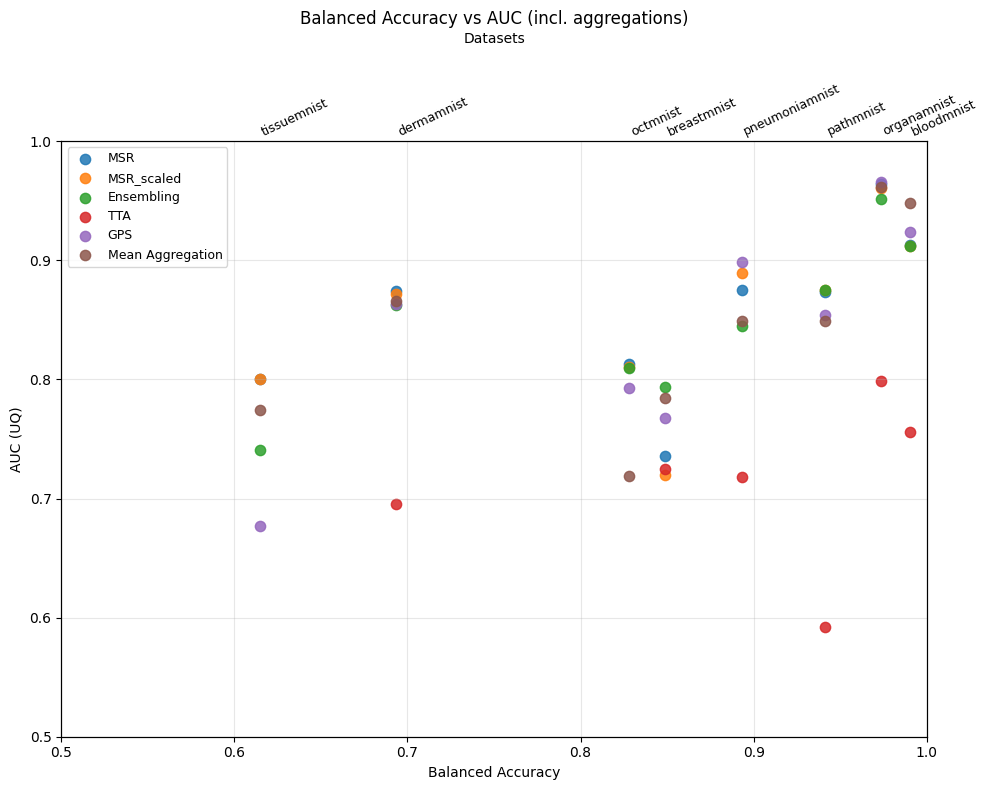

,dataset,method,balanced_accuracy,AUC
44,tissuemnist,Ensembling,0.614679,0.740414
8,breastmnist,Ensembling,0.848997,0.793315
20,octmnist,Ensembling,0.828000,0.809347
38,pneumoniamnist,Ensembling,0.893162,0.844669
14,dermamnist,Ensembling,0.693453,0.862091
32,pathmnist,Ensembling,0.941470,0.875242
2,bloodmnist,Ensembling,0.990139,0.912175
26,organamnist,Ensembling,0.973451,0.951512
46,tissuemnist,GPS,0.614679,0.676702
10,breastmnist,GPS,0.848997,0.767576


,dataset,method,balanced_accuracy,AUC
0,bloodmnist,MSR,0.990139,0.912607
1,bloodmnist,MSR_scaled,0.990139,0.911610
2,bloodmnist,Ensembling,0.990139,0.912175
3,bloodmnist,TTA,0.990139,0.755500
4,bloodmnist,GPS,0.990139,0.923828
5,bloodmnist,Mean Aggregation,0.990139,0.948324
6,breastmnist,MSR,0.848997,0.736074
7,breastmnist,MSR_scaled,0.848997,0.719939
8,breastmnist,Ensembling,0.848997,0.793315
9,breastmnist,TTA,0.848997,0.724933


In [36]:
plot_uq_or_aurc_vs_bacc(plot='AUC', include_aggs=True)

In [ ]:


# Collect points per method across all datasets + x tick mapping
method_to_xy = {}        # method -> (xs, ys)
ds_to_x = {}             # dataset -> x (balanced_accuracy)
for ds in sorted(results.keys()):
    try:
        x_src = results[ds]['class_perf']['balanced_accuracy']
        y_src = results[ds]['aucs_UQ']
    except KeyError:
        continue

    x = to_scalar(x_src)
    if not np.isfinite(x):
        continue
    ds_to_x[ds] = x

    # Start with stored method AUCs (from .pkl)
    if isinstance(y_src, dict):
        items = list(y_src.items())
    elif isinstance(y_src, (list, tuple)) and y_src and isinstance(y_src[0], (list, tuple)) and len(y_src[0]) == 2:
        items = list(y_src)
    else:
        items = [('UQ', y_src)]

    # Add aggregation AUCs computed from UQ vectors
    try:
        uq_dict = dict(results[ds]['uq_metrics'])
        labels_sf = success_failure_dict.get(ds, None)
    except Exception:
        uq_dict, labels_sf = None, None

    if uq_dict is not None and labels_sf is not None and len(labels_sf):
        base_for_agg = ['MSR_temp_scale', 'Ensembling', 'GPS']#, 'KNNshap']
        cols = [np.asarray(uq_dict[m], dtype=float) for m in base_for_agg if m in uq_dict]
        if len(cols) >= 2:
            mat = np.column_stack(cols)
            agg_vecs = {
                'Mean Aggregation': uq.standardize_and_ensemble(mat, 'mean'),
                #'Min Aggregation':  uq.standardize_and_ensemble(mat, 'min'),
                #'Max Aggregation':  uq.standardize_and_ensemble(mat, 'max'),
            }
            # Compute AUC_UQ for each aggregation
            lbls = np.asarray(labels_sf, dtype=int).reshape(-1)
            pos_idx = np.where(lbls == 1)[0]   # correct
            neg_idx = np.where(lbls == 0)[0]   # incorrect
            for name, vec in agg_vecs.items():
                corr_vals = [vec[i] for i in pos_idx.tolist()]
                inc_vals  = [vec[i] for i in neg_idx.tolist()]
                try:
                    _, _, auc_val = uq.roc_curve_UQ_method_computation(corr_vals, inc_vals)
                except Exception:
                    auc_val = np.nan
                items.append((name, auc_val))

    # Scatter data collection
    for method, val in items:
        y = to_scalar(val)
        if not np.isfinite(y):
            continue
        xs, ys = method_to_xy.setdefault(method, ([], []))
        xs.append(x); ys.append(y)

if not method_to_xy:
    print("No valid points to plot.")
else:
    plt.figure(figsize=(10,8))
    for method, (xs, ys) in sorted(method_to_xy.items()):
        label = {'MSR_temp_scale': 'MSR_scaled'}.get(method, method)
        plt.scatter(xs, ys, s=50, alpha=0.85, label=label)

    # Identity line
    all_x = [x for xs, _ in method_to_xy.values() for x in xs]
    all_y = [y for _, ys in method_to_xy.values() for y in ys]
    mn, mx = min(all_x + all_y), max(all_x + all_y)
    mn, mx = max(0.0, mn), min(1.0, mx)
    plt.plot([mn, mx], [mn, mx], 'k--', lw=1)

    # Axes, labels
    plt.xlim(0.5, 1); plt.ylim(0.5, 1)
    plt.xlabel('Balanced Accuracy (class_perf)')
    plt.ylabel('AUC (UQ)')
    plt.title('Classification perf vs UQ perf (incl. aggregations)')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right', fontsize=8, frameon=True)

    ax = plt.gca()
    ax.set_xlim(0.5, 1.0)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.05))
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    ax.tick_params(axis='x', which='major', labelbottom=True)

    # Top: dataset names at their x positions
    if ds_to_x:
        pairs = sorted(ds_to_x.items(), key=lambda kv: kv[1])
        tickpos = [v for _, v in pairs]
        ticklabels = [k for k, _ in pairs]

        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(tickpos)
        ax_top.set_xticklabels(ticklabels, rotation=25, ha='left', fontsize=9, fontstyle='oblique')
        ax_top.tick_params(axis='x', length=0, pad=2)
        ax_top.set_xlabel('Datasets', labelpad=28, fontsize=10)

    plt.tight_layout()
    plt.show()

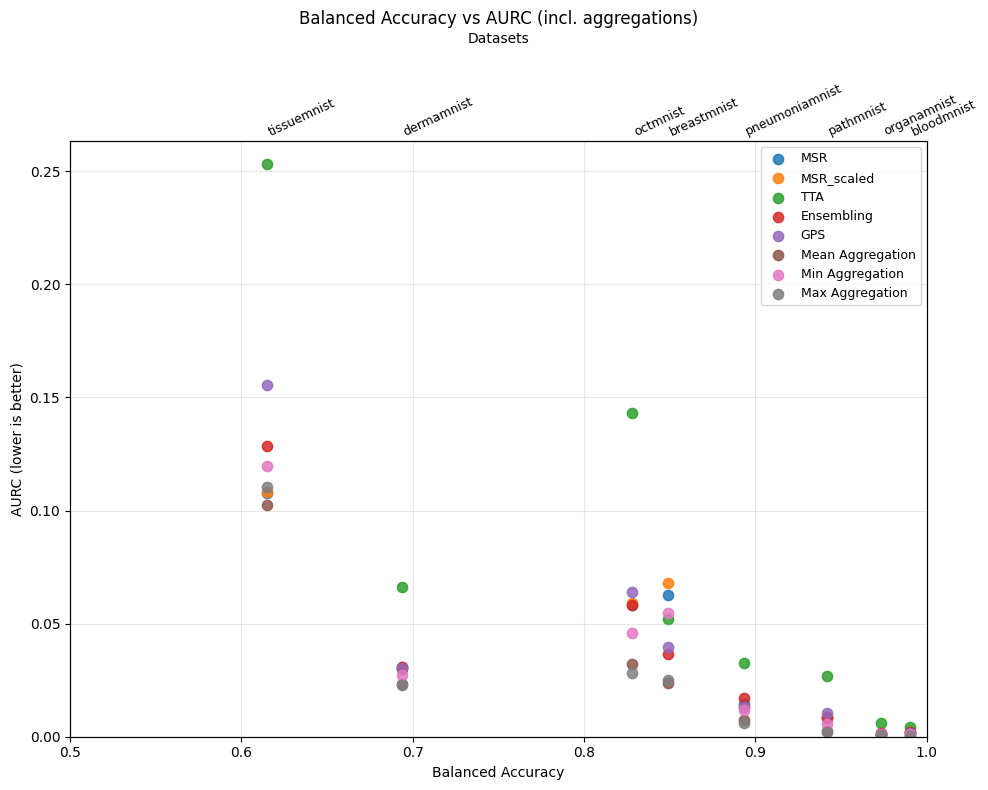

,dataset,method,balanced_accuracy,AURC
35,organamnist,Ensembling,0.973451,0.001489
3,bloodmnist,Ensembling,0.990139,0.001977
43,pathmnist,Ensembling,0.941470,0.008379
51,pneumoniamnist,Ensembling,0.893162,0.017337
19,dermamnist,Ensembling,0.693453,0.030653
...,...,...,...,...
50,pneumoniamnist,TTA,0.893162,0.032723
10,breastmnist,TTA,0.848997,0.052168
18,dermamnist,TTA,0.693453,0.066264
26,octmnist,TTA,0.828000,0.143168


,dataset,method,balanced_accuracy,AURC
0,bloodmnist,MSR,0.990139,0.001986
1,bloodmnist,MSR_scaled,0.990139,0.001993
2,bloodmnist,TTA,0.990139,0.004099
3,bloodmnist,Ensembling,0.990139,0.001977
4,bloodmnist,GPS,0.990139,0.001505
...,...,...,...,...
59,tissuemnist,Ensembling,0.614679,0.128598
60,tissuemnist,GPS,0.614679,0.155635
61,tissuemnist,Mean Aggregation,0.614679,0.102288
62,tissuemnist,Min Aggregation,0.614679,0.119760


In [30]:
plot_uq_or_aurc_vs_bacc(plot='AURC', methods=methods_to_plot, include_aggs=True)

In [ ]:
import math

methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA', 'GPS', 'KNNshap']  # adapt if needed
display_name = {'MSR_temp_scale': 'MSR_scaled'}

def compute_aurc(uq_values, success_labels):
    """
    uq_values: iterable of uncertainty scores (lower = more confident)
    success_labels: list/array of 0/1 (1 = correct prediction)
    """
    v = torch.tensor(uq_values, dtype=torch.float32)
    lab = torch.tensor(success_labels, dtype=torch.float32)
    if len(v) != len(lab) or len(v) == 0:
        return math.nan
    order = torch.argsort(v, descending=False)
    ordered_lab = lab[order]
    k = torch.arange(1, len(v)+1, dtype=torch.float32)
    cum_correct = torch.cumsum(ordered_lab, dim=0)
    accuracy_prefix = cum_correct / k
    risk = 1.0 - accuracy_prefix  # error rate among retained
    coverage = k / len(v)
    aurc = torch.trapz(risk, coverage).item()
    return aurc

# Collect points
# method_points[method] -> (list_x_bal_acc, list_y_aurc)
method_points = {m: ([], []) for m in methods}
table_rows = []
ds_to_x = {}

for ds in sorted(results.keys()):
    # Balanced accuracy
    try:
        bal_acc = float(results[ds]['class_perf']['balanced_accuracy'])
    except Exception:
        continue
    if not (0 <= bal_acc <= 1):
        continue

    # Success/failure labels
    if ds not in success_failure_dict:
        continue
    labels_sf = success_failure_dict[ds]

    # UQ metrics (convert to dict)
    try:
        uq_dict = dict(results[ds]['uq_metrics'])
    except Exception:
        continue

    for m in methods:
        if m not in uq_dict:
            continue
        aurc_val = compute_aurc(uq_dict[m], labels_sf)
        if not np.isfinite(aurc_val):
            continue
        # Record dataset balanced accuracy once (after confirming at least one valid UQ point)
        if ds not in ds_to_x:
            ds_to_x[ds] = bal_acc
        xs, ys = method_points[m]
        xs.append(bal_acc)
        ys.append(aurc_val)
        table_rows.append({
            'dataset': ds,
            'method': display_name.get(m, m),
            'balanced_accuracy': bal_acc,
            'AURC': aurc_val
        })

# Plot
if all(len(v[0]) == 0 for v in method_points.values()):
    print("No points to plot.")
else:
    plt.figure(figsize=(10,8))
    for m, (xs, ys) in method_points.items():
        if not xs:
            continue
        plt.scatter(xs, ys, s=55, alpha=0.85, label=display_name.get(m, m))

    plt.xlabel('Balanced Accuracy')
    plt.ylabel('AURC (lower is better)')
    plt.title('Balanced Accuracy vs AURC per UQ Method & Dataset')
    plt.xlim(0.5, 1.0)
    # y-range adaptive
    all_y = [y for _, ys in method_points.items() for y in ys[1]]
    if all_y:
        ymin = max(0.0, min(all_y) - 0.01)
        ymax = min(1.0, max(all_y) + 0.01)
        plt.ylim(ymin, ymax)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=9)

    # Added: dataset name ticks on a twin top axis
    if ds_to_x:
        ax = plt.gca()
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        # Sort by balanced accuracy so labels are ordered
        pairs = sorted(ds_to_x.items(), key=lambda kv: kv[1])
        tick_pos = [v for _, v in pairs]
        tick_lbl = [k for k, _ in pairs]
        ax_top.set_xticks(tick_pos)
        ax_top.set_xticklabels(tick_lbl, rotation=25, ha='left', fontsize=9)
        ax_top.tick_params(axis='x', length=0, pad=2)
        ax_top.set_xlabel('Datasets', labelpad=28, fontsize=10)

    plt.tight_layout()
    plt.show()

# Optional summary table
try:
    import pandas as pd
    df_aurc = pd.DataFrame(table_rows)
    if not df_aurc.empty:
        display(df_aurc.sort_values(['method','AURC']))
except ImportError:
    pass

In [ ]:
# ...existing code...

def plot_auc_vs_aurc(methods=None):
    """
    Scatter plot AUC_UQ (x) against AURC (y) for all datasets and methods.
    Uses compute_aurc for AURC and results[...] for AUC_UQ.
    Adds dataset names as ticks on a top axis (at mean AUC_UQ per dataset).
    """
   
    import pandas as pd

    # Default to all methods present in results if not provided
    if methods is None:
        methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA', 'GPS', 'KNNshap']

    points = []            # (auc_uq, aurc, ds, method)
    ds_to_auc_list = {}    # dataset -> list of auc_uq (for tick positions)

    for ds in sorted(results.keys()):
        # Success/failure labels for this dataset
        if ds not in success_failure_dict:
            continue
        labels_sf = success_failure_dict[ds]

        # UQ metrics and AUC_UQ storage
        try:
            uq_dict = dict(results[ds]['uq_metrics'])          # method -> list of UQ values
            aucs_UQ_raw = results[ds].get('aucs_UQ', None)     # dict or list of pairs
        except Exception:
            continue

        # Normalize aucs_UQ to a dict
        aucs_UQ = {}
        if isinstance(aucs_UQ_raw, dict):
            aucs_UQ = aucs_UQ_raw
        elif isinstance(aucs_UQ_raw, (list, tuple)):
            for m, v in aucs_UQ_raw:
                aucs_UQ[m] = v

        for m in methods:
            if m not in uq_dict or m not in aucs_UQ:
                continue
            # AUC_UQ from results (.pkl)
            auc_uq = aucs_UQ[m]
            if auc_uq is None or not np.isfinite(auc_uq):
                continue
            # AURC from compute_aurc()
            aurc_val = compute_aurc(uq_dict[m], labels_sf)
            if not np.isfinite(aurc_val):
                continue

            points.append((float(auc_uq), float(aurc_val), ds, m))
            ds_to_auc_list.setdefault(ds, []).append(float(auc_uq))

    if not points:
        print("No valid AUC_UQ and AURC pairs found.")
        return pd.DataFrame()

    # Plot
    plt.figure(figsize=(10, 8))
    # Color/marker by method
    methods_present = sorted({m for _, _, _, m in points})
    method_to_xy = {m: ([], []) for m in methods_present}
    for auc_uq, aurc_val, ds, m in points:
        xs, ys = method_to_xy[m]
        xs.append(auc_uq); ys.append(aurc_val)

    for m in methods_present:
        xs, ys = method_to_xy[m]
        if xs:
            plt.scatter(xs, ys, s=60, alpha=0.85, label=m)

    plt.xlabel('AUC_UQ')
    plt.ylabel('AURC (lower is better)')
    plt.title('AUC_UQ vs AURC for all datasets and methods')
    plt.grid(True, alpha=0.3)

    # Axis limits
    all_x = [p[0] for p in points]
    all_y = [p[1] for p in points]
    xmin = max(0.0, min(all_x) - 0.01)
    xmax = min(1.0, max(all_x) + 0.01)
    ymin = max(0.0, min(all_y) - 0.01)
    ymax = min(1.0, max(all_y) + 0.01)
    plt.xlim(max(0.5, xmin), max(0.5, xmax))  # keep typical range [0.5, 1]
    plt.ylim(ymin, ymax)

    # Legend (deduplicate if needed)
    handles, labels = plt.gca().get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    plt.legend(uniq.values(), uniq.keys(), fontsize=8, loc='best')

    plt.tight_layout()
    plt.show()

    # Return a DataFrame of the plotted points for reference
    df = pd.DataFrame(points, columns=['AUC_UQ', 'AURC', 'dataset', 'method'])
    return df

# ...existing code...

In [ ]:
plot_auc_vs_aurc()  # Call the function to generate the plot

In [ ]:
def apply_softmax(y):
    y_scores = np.array(F.softmax(torch.tensor(y), dim=1))
    return y_scores

In [ ]:
def test_eval(test_loader, device, models, data_flag):
    info = INFO[data_flag]
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes

    # Perform inference on the test set
    y_true = []
    y_scores = []
    y_raw_digits = []
    indiv_scores = [[] for _ in range(len(models))]  # Store individual model scores

    for m in models:
        m.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = [model(data) for model in models]

            # Store individual model scores
            for i, output in enumerate(outputs):
                if task_type == 'binary-class':
                    indiv_scores[i].extend(F.sigmoid(output).cpu().numpy().flatten())
                else:
                    indiv_scores[i].extend(F.softmax(output, dim=1).cpu().numpy())

            # Average the outputs for ensemble prediction
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            y_true.extend(target.cpu().numpy().flatten())
            if task_type == 'binary-class':
                avg_output_sig = F.sigmoid(avg_output)
                y_scores.extend(avg_output_sig.cpu().numpy().flatten())
                y_raw_digits.extend(avg_output.cpu().numpy().flatten())
            else:
                y_scores.extend(avg_output.cpu().numpy())
                y_raw_digits.extend(avg_output.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_scores_raw_digits = np.array(y_raw_digits)

    if task_type == 'binary-class':
        y_pred = (y_scores > 0.5).astype(int)
        auc = roc_auc_score(y_true, y_scores)
    else:
        y_pred = np.argmax(y_scores, axis=1)
        # Calculate metrics
        auc = roc_auc_score(y_true, apply_softmax(y_scores), multi_class='ovr')
    acc = accuracy_score(y_true, y_pred)
    print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

    # Generate the confusion matrix
    if task_type == 'binary-class':
        cm = confusion_matrix(y_true, y_pred)
    else:
        cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute balanced accuracy
    if task_type == 'binary-class':
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
    else:
        balanced_acc = balanced_accuracy_score(y_true, y_scores.argmax(axis=1))

    # Compute sensitivity (recall)
    if task_type == 'binary-class':
        sensitivity = recall_score(y_true, y_pred, average='binary')
    else:
        sensitivity = recall_score(y_true, y_scores.argmax(axis=1), average='macro')
    

    # Compute specificity
    specificities = []
    for i in range(num_classes):
        if task_type == 'binary-class':
            cm = confusion_matrix(y_true, y_pred)
        else:
            cm = confusion_matrix(y_true, y_scores.argmax(axis=1))
        FP = np.sum(cm[:, i]) - cm[i, i]  # False Positives
        TN = np.sum(cm) - (np.sum(cm[i, :]) + FP)  # True Negatives
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 1.0
        specificities.append(specificity)

    macro_specificity = np.mean(specificities)

    perfs = {
        'auc': auc,
        'accuracy': acc,
        'balanced_accuracy': balanced_acc,
        'sensitivity': sensitivity,
        'specificity': macro_specificity,
        'confusion_matrix': cm
    }
    print(perfs)
    return y_true, y_scores, y_scores_raw_digits, indiv_scores, perfs

In [ ]:
# Add picklable callables
class RepeatGrayToRGB:
    def __call__(self, x):
        return x.repeat(3, 1, 1)

In [ ]:
flags = ['breastmnist', 'organamnist', 'pneumoniamnist', 'dermamnist', 'octmnist', 'pathmnist', 'bloodmnist', 'tissuemnist']
calib_method = ['platt', 'temperature', 'platt', 'temperature', 'temperature', 'temperature', 'temperature', 'temperature']
colors = [False, False, False, True, False, True, True, False]  # Colors for the flags
activations = ['sigmoid', 'softmax', 'sigmoid', 'softmax', 'softmax', 'softmax', 'softmax', 'softmax']  # Output activations for each flag
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
uq_methods = ['MSR', 'MSR_temp_scale', 'Ensembling', 'TTA', 'GPS', 'KNNshap']#, 'KNNshap', 'KNNall']  
size = 224  # Image size for the models
batch_size = 4000  # Batch size for the DataLoader
correct_predictions = {}
incorrect_predictions  = {}
correct_predictions_calibration = {}
incorrect_predictions_calibration = {}

for flag, color, activation, calib_method in zip(flags, colors, activations, calib_method):
    print(f"Processing {flag} with color={color} and activation={activation}")
    
    with open(f'/mnt/data/psteinmetz/archive_notebooks/Documents/medMNIST/shap/{size}*{size}/shap_results_calibration_{flag}.pkl', 'rb') as f:  # with statement avoids file leak
        shap_results = pkl.load(f)
        latent_spaces = shap_results['latent_spaces']
        shap_values_folds = shap_results['shap_values_folds']
        labels_fold = shap_results['success_folds']

    if color is True:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor()
        ])
    else:
        # For grayscale images, repeat the single channel to make it compatible with ResNet
        # ResNet expects 3 channels, so we repeat the single channel image
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5]),
            RepeatGrayToRGB(),
        ])
        
        transform_tta = transforms.Compose([
            transforms.ToTensor(),
            RepeatGrayToRGB(),
            ])
    models = tr.load_models(flag, device=device)
    [train_dataset, calibration_dataset, test_dataset], [_, calibration_loader, test_loader], info = tr.load_datasets(flag, color, size, transform, batch_size)
    
    task_type = info['task']  # Determine the task type (binary-class or multi-class)
    num_classes = len(info['label'])  # Number of classes
    [_, calibration_dataset_tta, test_dataset_tta], [_, calibration_loader_tta, test_loader_tta], _ = tr.load_datasets(flag, color, size, transform_tta, batch_size)

    y_true, y_scores, digits, indiv_scores, performances = test_eval(test_loader, device=device, models=models, data_flag=flag)
    y_true_calibration, y_scores_calibration, digits_calib, indiv_scores_calib, performances_calib = test_eval(calibration_loader, device=device, models=models, data_flag=flag)

    if task_type == 'binary-class':
        y_prob = y_scores
        y_prob_calibration = y_scores_calibration
    else:
        y_prob = apply_softmax(y_scores)
        y_prob_calibration = apply_softmax(y_scores_calibration)

    if task_type == 'binary-class':
        correct_idx = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] > 0.5) or (y_true[i] == 0 and y_scores[i] <= 0.5)]
        incorrect_idx = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_scores[i] <= 0.5) or (y_true[i] == 0 and y_scores[i] > 0.5)]

        correct_idx_calib = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] > 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] <= 0.5)]
        incorrect_idx_calib = [i for i in range(len(y_true_calibration)) if (y_true_calibration[i] == 1 and y_scores_calibration[i] <= 0.5) or (y_true_calibration[i] == 0 and y_scores_calibration[i] > 0.5)]
    else:
        correct_idx = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
        incorrect_idx = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

        correct_idx_calib = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
        incorrect_idx_calib = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]
    # Store results in the dicts defined at the top (avoid overwriting them with lists)
    correct_predictions[flag] = correct_idx
    incorrect_predictions[flag] = incorrect_idx
    correct_predictions_calibration[flag] = correct_idx_calib
    incorrect_predictions_calibration[flag] = incorrect_idx_calib
   

In [ ]:
calibration_dataset

In [ ]:
from collections import Counter
import pandas as pd

# Compute number of images per class in calibration_dataset (tissuemnist)

# Try fast path using underlying labels array
try:
    base_ds = calibration_dataset.dataset
    idxs = calibration_dataset.indices
    raw_labels = base_ds.labels[idxs].squeeze()
    # Ensure 1D numpy array of ints
    labels_np = np.array(raw_labels, dtype=int).reshape(-1)
    counts_arr = np.bincount(labels_np, minlength=len(info['label']))
    class_counts = {cls: int(counts_arr[cls]) for cls in range(len(counts_arr))}
except Exception:
    # Fallback: iterate through subset
    class_counts = Counter()
    for _, target in calibration_dataset:
        class_counts[int(target)] += 1

# Map IDs to human-readable class names
id_to_name = {int(k): v for k, v in info['label'].items()}

total = sum(class_counts.values())
rows = []
for cls_id in sorted(class_counts.keys()):
    cnt = class_counts[cls_id]
    rows.append({
        'class_id': cls_id,
        'class_name': id_to_name.get(cls_id, f'class_{cls_id}'),
        'count': cnt,
        'percent': 100.0 * cnt / total if total else 0.0
    })

calib_df = pd.DataFrame(rows)
calib_df_sorted = calib_df.sort_values('count', ascending=False).reset_index(drop=True)
print(f"Total images in calibration_dataset: {total}")
display(calib_df_sorted)

In [ ]:
mean_values_flags = {}
min_values_flags = {}
max_values_flags = {}
for flag in flags:
    uq_metrics = results[flag]['uq_metrics']
    mean_values = uq.standardize_and_ensemble(
     np.column_stack(
			[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']]
		), 'mean'
	)
    min_values = uq.standardize_and_ensemble(
		np.column_stack(
			[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']]
		), 'min'
	)
    max_values = uq.standardize_and_ensemble(
		np.column_stack(
			[uq_metrics[i][1] for i in range(len(uq_metrics)) if uq_metrics[i][0] in ['MSR_temp_scale', 'Ensembling', 'GPS', 'KNNshap']]
		), 'max'
	)
    mean_values_flags[flag] = mean_values
    min_values_flags[flag] = min_values
    max_values_flags[flag] = max_values

In [ ]:
def find_best_threshold_and_compute_metrics(values, correct_predictions, optimization_metric='balanced_accuracy'):
    """
    Find the best threshold and compute metrics.

    Args:
        values (numpy.ndarray): UQ values.
        correct_predictions (list): Indices of correct predictions.
        optimization_metric (str): Metric to optimize ('balanced_accuracy', 'sensitivity', 'specificity').

    Returns:
        None
    """
    # Function to compute metrics
    def compute_metrics(uq_values, labels, threshold):
        predictions = (uq_values <= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        balanced_acc = balanced_accuracy_score(labels, predictions)
        return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

    # Update the function to handle ties in specificity or sensitivity
    def find_optimal_threshold(uq_values, labels, metric):
        thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
        best_threshold = thresholds[0]
        best_metric_value = 0
        best_secondary_metric_value = 0

        for threshold in thresholds:
            _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)

            if metric == 'balanced_accuracy' and balanced_acc > best_metric_value:
                best_metric_value = balanced_acc
                best_threshold = threshold
            elif metric == 'sensitivity':
                if sensitivity > best_metric_value or (sensitivity == best_metric_value and specificity > best_secondary_metric_value):
                    best_metric_value = sensitivity
                    best_secondary_metric_value = specificity
                    best_threshold = threshold
            elif metric == 'specificity':
                if specificity > best_metric_value or (specificity == best_metric_value and sensitivity > best_secondary_metric_value):
                    best_metric_value = specificity
                    best_secondary_metric_value = sensitivity
                    best_threshold = threshold

        return best_threshold

    # Find the optimal threshold
    labels = np.array([1 if i in correct_predictions else 0 for i in range(len(values))])
    optimal_threshold = find_optimal_threshold(values, labels, optimization_metric)

    # Compute the confusion matrix using the optimal threshold
    predictions = (values <= optimal_threshold).astype(int)
    cm = confusion_matrix(labels, predictions)
    
    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 36}, xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Print the optimal threshold and metrics
    _, _, _, _, specificity, sensitivity, balanced_acc = compute_metrics(values, labels, optimal_threshold)
    
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Specificity: {specificity}")
    print(f"Sensitivity: {sensitivity}")

    return balanced_acc

In [ ]:
def display_UQ_results(metric, correct_predictions, incorrect_predictions, y_axis_title, title, optim_metric, swarmplot=False):
    balanced_acc = find_best_threshold_and_compute_metrics(metric, correct_predictions, optim_metric)
    fpr, tpr, auc = uq.roc_curve_UQ_method_computation([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions])
    uq.UQ_method_plot([metric[k] for k in correct_predictions], [metric[j] for j in incorrect_predictions], y_axis_title, title, swarmplot)
    print(auc)
    return auc, balanced_acc

In [ ]:
flags

In [ ]:
len(mean_values)

In [ ]:
mean_balanced_accuracies = {}
for flag in flags:
    print(flag)
    auc, balanced_acc = display_UQ_results(mean_values_flags[flag], correct_predictions[flag], incorrect_predictions[flag], 'Mean(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='balanced_accuracy', swarmplot=False)
    mean_balanced_accuracies[flag] = balanced_acc

In [ ]:
min_balanced_accuracies = {}
for flag in flags:
    print(flag)
    auc, balanced_acc = display_UQ_results(min_values_flags[flag], correct_predictions[flag], incorrect_predictions[flag], 'Min(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='balanced_accuracy', swarmplot=False)
    min_balanced_accuracies[flag] = balanced_acc

In [ ]:
max_balanced_accuracies = {}
for flag in flags:
    print(flag)
    auc, balanced_acc = display_UQ_results(max_values_flags[flag], correct_predictions[flag], incorrect_predictions[flag], 'Max(Zscore(UQ metrics))', 'UQ methods combination', optim_metric='balanced_accuracy', swarmplot=False)
    max_balanced_accuracies[flag] = balanced_acc